In [204]:
%matplotlib inline

In [984]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import spacy

from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# pip install spacy
# pip install https://huggingface.co/sakelariev/bg_news_lg/resolve/main/bg_news_lg-3.5.4-py3-none-any.whl
# https://github.com/sakelariev/bulgarian-spacy-modelsimport spacy

# Analysis of the hotels in the Bulgarian Black Sea resort town Sozopol

## Abstract

This project presents data science research focusing on the analysis of hotels in Sozopol - one of the most famous Bulgarian Black Sea resort towns. The data for this project was collected through web scraping from different websites that provide information about hotel details and reviews. The data is intended only for educational and research purposes. It is for demonstrating data analysis methods. It isn't used for advertising, commercial purposes or any other misuse.

## Contents

1. [Data collection](./data_scraping.ipynb)
2. Description of data
3. Project objectives
4. Data tidying, cleaning, EDA
5. Results and conclusion

## 2. Description of the datasets

The data was collected through web scraping on 12 August 2024 (in [data scraping notebook](./data_scraping.ipynb)) from two different websites: https://pochivka.bg/ and https://booking.com. The collected data was converted into DataFrames. There are two datasets: one structured dataset and one unstructured dataset. 

**First dataset** ([hotels_data](data/hotels_data.csv)) includes hotel details: name of the hotel, how many stars is the hotel, location, rating, amenities in the rooms that the hotel offers, different room types (3 - if there is, or less), for each room type there is  information how many people can stay in it and price for summer season.

**Second dataset** ([reviews_hotels_data](data/reviews_hotels_data.csv)) includes information about latest customers reviews (25 if there is, or less): name of the hotel, overall rating from the person writing the review, positive and negative part from the review. 

The link between the two datasets is the name of the hotel (hotel_name). 

## 3. Project objectives

**1. Analysis of hotels in Sozopol**: It covers the study of the distribution of stars, the availability of amenities, the distribution of prices, ratings, in order to identify the main factors affecting their market position.
   
**2. Identification of the best hotels**: Determining which hotels offers the best value for money, stars, amenities, customers rating and reviews.

Results are important for hoteliers - they could optimize pricing strategies, improve service offerings and generally understand the factors that determine customer satisfaction. This will help hoteliers to  understand their position in the market and increase their competitiveness. Identifying which hotel offers the best value relative to amenities, stars, price, and ratings allows hoteliers to understand their position in the market. By understanding which factors contribute most to customer satisfaction and ratings, hoteliers can focus their investments on those areas, thereby optimizing their resources and maximizing revenue. They can benchmark their offerings against competitors, adjust prices, improve amenities, or enhance service quality to attract more customers. 

For these goals, it is essential to have complete data. Missing values can distort analysis and lead to incorrect conclusions. I try to fill in missing data with the most suitable and relevant values ​​for the corresponding column.

## 4. Data tidying, cleaning, EDA

First I take a look at the data and transform it into a convenient format for the purposes of the project. 

### Hotels details dataset:

In [730]:
hotels_data = pd.read_csv('data/hotels_data.csv')

In [731]:
hotels_data.sample(3)

,hotel_name,hotel_stars_count,location,rating,room_type1,occupancy1,summer_price1,room_type2,occupancy2,summer_price2,room_type3,occupancy3,summer_price3,amenities_list
137,Семеен хотел Ленивият слон,3.0,Созопол,NaN,стандартна стая,2.0,70 лв,апартамент,3.0,200 лв,NaN,NaN,NaN,"['паркинг', 'телевизор', 'кухня', 'кабелна тв'..."
62,Семеен хотел Калипсо,3.0,Созопол,NaN,стандартна стая,2.0,70 лв,NaN,NaN,NaN,NaN,NaN,NaN,"['телевизор', 'кабелна тв', 'климатик', 'хлади..."
30,Хотел Дриймс,3.0,Созопол,NaN,апартамент,4.0,100 лв,NaN,NaN,NaN,NaN,NaN,NaN,"['паркинг', 'ресторант', 'охрана', 'сейф', 'де..."


In [671]:
hotels_data.shape

(215, 14)

In [672]:
hotels_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   hotel_name         215 non-null    object 
 1   hotel_stars_count  181 non-null    float64
 2   location           215 non-null    object 
 3   rating             135 non-null    float64
 4   room_type1         210 non-null    object 
 5   occupancy1         210 non-null    float64
 6   summer_price1      210 non-null    object 
 7   room_type2         192 non-null    object 
 8   occupancy2         192 non-null    float64
 9   summer_price2      192 non-null    object 
 10  room_type3         144 non-null    object 
 11  occupancy3         144 non-null    float64
 12  summer_price3      144 non-null    object 
 13  amenities_list     215 non-null    object 
dtypes: float64(5), object(9)
memory usage: 23.6+ KB


In [732]:
hotels_data.rename(columns={
    'hotel_name': 'name',
    'hotel_stars_count': 'stars',
    'amenities_list': 'amenities',
    'occupancy1' : 'ocp1',
    'occupancy2' : 'ocp2',
    'occupancy3' : 'ocp3',
}, inplace = True)

In [687]:
hotels_data.location.value_counts()

location
Созопол       214
Черноморец      1
Name: count, dtype: int64

In [688]:
hotels_data[hotels_data.location == "Черноморец"] 

,name,stars,location,rating,room_type1,ocp1,summer_price1,room_type2,ocp2,summer_price2,room_type3,ocp3,summer_price3,amenities
121,Хотел Парадайс Гардън,NaN,Черноморец,NaN,студио,2.0,180 лв,студио,3.0,200 лв,апартамент,5.0,355 лв,"['открит басейн', 'паркинг', 'ресторант', 'охр..."


I remove hotel 'Парадайс Гардън' because it isnt in Sozopol. Then I remove the 'location' column because it doesn't bring me any information - it has low entropy.

In [733]:
hotels_data = hotels_data.drop(index = 121)

In [734]:
hotels_data = hotels_data.drop(columns = 'location')

I check the prices columns and I see that it needs cleaning and tidying. I clean the price columns from currency and empty spaces. Then i create new columns for double room prices and triple room prices. This transformation makes the data appropriate for my analysis.

In [654]:
hotels_data.summer_price1.unique()

array(['70 лв', '170 лв', '176 лв', '100 лв', '135 лв', nan, '220 лв',
       '400 лв', '315 лв', '80 лв', '140 лв', '180 лв', '139 лв',
       '160 лв', '285 лв', '247 лв', '172 лв', '244 лв', '290 лв',
       '60 лв', '30 лв', '359 лв', '40 лв', '150 лв', '50 лв', '90 лв',
       '218 лв', '380 лв', '85 лв', '128 лв', 'не се дава', '300 лв',
       '75 лв', '130 лв', '153 лв', '120 лв', '138 лв', '72 лв', '108 лв',
       '45 лв', '65 лв', '240 лв', '200 лв', '145 лв', '143 лв', '115 лв',
       '110 лв', '1600 лв', 'няма цена', '109 лв', '207 лв', '149 лв',
       '119 лв', '98 лв', '370 лв', '95 лв', '190 лв', '49 лв', '250 лв',
       '323 лв', '1100 лв', '210 лв', '980 лв', '600 лв', '246 лв',
       '94 лв', '55 лв', '126 лв', '66 лв', '102 лв', '156 лв', '360 лв'],
      dtype=object)

In [655]:
hotels_data.summer_price2.unique()

array(['90 лв', '200 лв', '195 лв', '100 лв', '156 лв', nan, '330 лв',
       '600 лв', '415 лв', '80 лв', '350 лв', '250 лв', '198 лв',
       '285 лв', '306 лв', '248 лв', '120 лв', '70 лв', '45 лв', '416 лв',
       '380 лв', '150 лв', '210 лв', '232 лв', '532 лв', '60 лв',
       '105 лв', '136 лв', '165 лв', '230 лв', '130 лв', '194 лв',
       '85 лв', '118 лв', '242 лв', '95 лв', 'не се дава', '110 лв',
       '65 лв', '190 лв', '140 лв', '115 лв', '180 лв', '160 лв',
       '220 лв', '170 лв', '175 лв', '119 лв', '75 лв', '277 лв',
       'няма цена', '40 лв', '55 лв', '139 лв', '282 лв', '169 лв',
       '146 лв', '545 лв', '59 лв', '50 лв', '430 лв', '288 лв', '98 лв',
       '410 лв', '1100 лв', '270 лв', '129 лв', '280 лв', '108 лв',
       '112 лв', '228 лв', '148 лв', '144 лв', '300 лв', '128 лв',
       '440 лв', '290 лв'], dtype=object)

In [656]:
hotels_data.summer_price3.unique()

array(['75 лв', '200 лв', '285 лв', '120 лв', '166 лв', nan, '460 лв',
       '515 лв', '95 лв', '290 лв', '198 лв', '240 лв', '370 лв',
       '321 лв', '258 лв', '160 лв', '60 лв', '80 лв', '54 лв', '458 лв',
       '300 лв', '140 лв', '110 лв', '400 лв', '85 лв', '190 лв', '90 лв',
       '250 лв', '208 лв', '138 лв', '130 лв', '100 лв', '150 лв',
       '210 лв', '155 лв', '350 лв', '170 лв', '125 лв', 'не се дава',
       '220 лв', '180 лв', '162 лв', 'няма цена', '69 лв', '148 лв',
       '510 лв', '135 лв', '74 лв', '295 лв', '495 лв', '299 лв', '84 лв',
       '548 лв', '115 лв', '1100 лв', '310 лв', '215 лв', '280 лв',
       '128 лв', '330 лв', '165 лв', '186 лв', '65 лв', '153 лв',
       '105 лв', '168 лв', '175 лв'], dtype=object)

In [735]:
def clean_price(price):
    if pd.isna(price) or price in ['не се дава', 'няма цена']:
        return np.nan
    return float(price.replace(' лв', ''))

hotels_data['summer_price1'] = hotels_data['summer_price1'].apply(clean_price)
hotels_data['summer_price2'] = hotels_data['summer_price2'].apply(clean_price)
hotels_data['summer_price3'] = hotels_data['summer_price3'].apply(clean_price)

In [736]:
def create_price_columns(row):
    row['price_double_room'] = np.nan
    row['price_big_room'] = np.nan

    if 2 in [row['ocp1'], row['ocp2'], row['ocp3']]:
        index = [row['ocp1'], row['ocp2'], row['ocp3']].index(2)
        price = [row['summer_price1'], row['summer_price2'], row['summer_price3']][index]
        if not pd.isna(price):
            row['price_double_room'] = price

    if any(ocp in [3, 4] for ocp in [row['ocp1'], row['ocp2'], row['ocp3']]):
        for ocp, price in zip([row['ocp1'], row['ocp2'], row['ocp3']], 
                              [row['summer_price1'], row['summer_price2'], row['summer_price3']]):
            if ocp in [3, 4] and not pd.isna(price):
                row['price_big_room'] = price
                break 

    return row

hotels_data = hotels_data.apply(create_price_columns, axis=1)

In [737]:
# drop unnecessary columns:
hotels_data.drop(columns = ['room_type1', 'ocp1', 'summer_price1',
                          'room_type2', 'ocp2', 'summer_price2',
                          'room_type3', 'ocp3','summer_price3'], inplace = True)

In [694]:
hotels_data.sample(3)

,name,stars,rating,amenities,price_double_room,price_big_room
161,Семеен хотел Логатеро,3.0,9.2,"['открит басейн', 'паркинг', 'рент-а-кар', 'се...",210.0,270.0
7,Хотел Каса де Оро,NaN,9.5,"['паркинг', 'кафене', 'телевизор', 'кухня', 'с...",NaN,400.0
82,Семеен хотел Ориндж хаус,3.0,6.8,"['паркинг', 'кафене', 'телевизор', 'кабелна тв...",60.0,60.0


Now I make some visualisations to explore the price data and check for outliers:

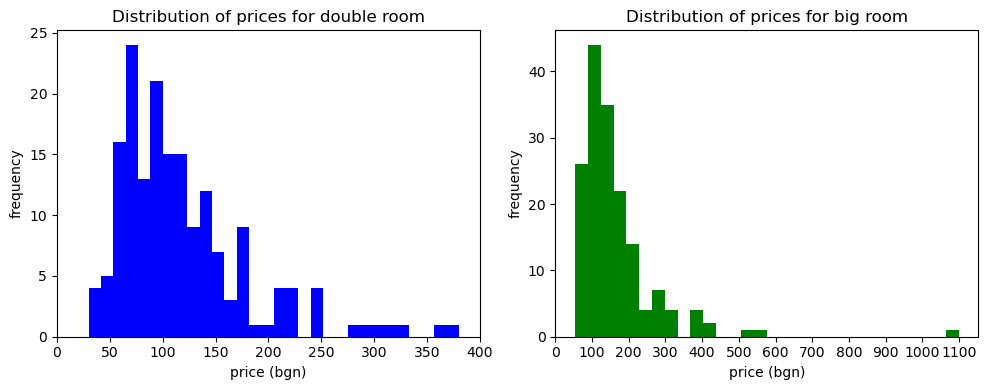

In [661]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

axes[0].hist(hotels_data.price_double_room, bins = 30, color = 'blue')
axes[0].set_xticks(range(0, 401, 50))
axes[0].set_xlabel('price (bgn)')
axes[0].set_ylabel('frequency')
axes[0].set_title("Distribution of prices for double room")

axes[1].hist(hotels_data.price_big_room, bins = 30, color = 'green')
axes[1].set_xticks(range(0, 1200, 100))
axes[1].set_xlabel('price (bgn)')
axes[1].set_ylabel('frequency')
axes[1].set_title("Distribution of prices for big room")

plt.tight_layout()
plt.show()

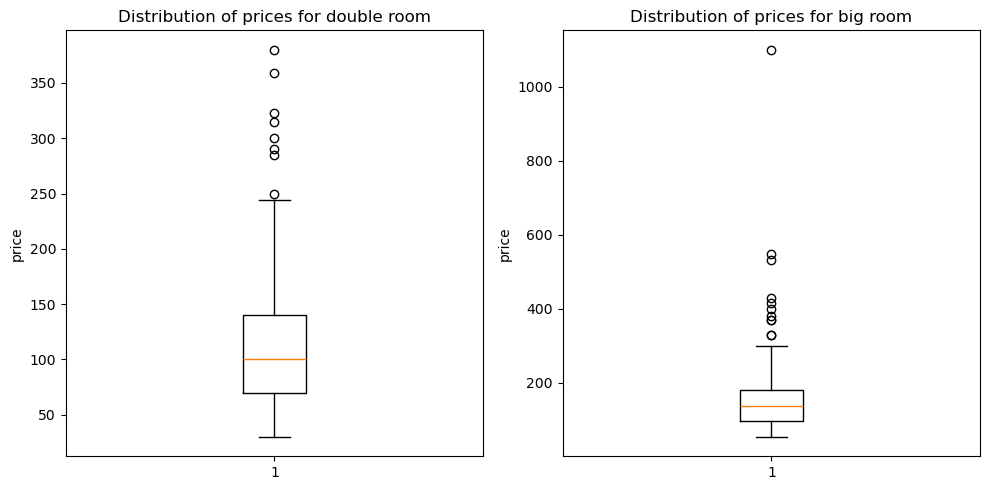

In [662]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].boxplot([hotels_data.price_double_room.dropna()], vert=True)
axes[0].set_title('Distribution of prices for double room')
axes[0].set_ylabel('price')

axes[1].boxplot([hotels_data.price_big_room.dropna()], vert=True)
axes[1].set_title('Distribution of prices for big room')
axes[1].set_ylabel('price')

plt.tight_layout()
plt.show()

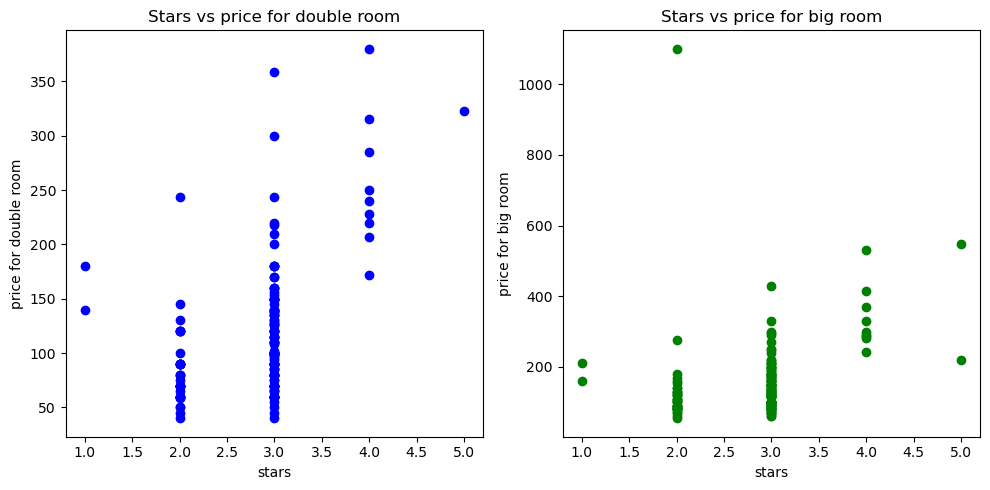

In [663]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

axes[0].scatter(hotels_data.stars, hotels_data.price_double_room, color = 'blue')
axes[0].set_title('Stars vs price for double room')
axes[0].set_xlabel('stars')
axes[0].set_ylabel('price for double room')

axes[1].scatter(hotels_data.stars, hotels_data.price_big_room, color = 'green')
axes[1].set_title('Stars vs price for big room')
axes[1].set_xlabel('stars')
axes[1].set_ylabel('price for big room')

plt.tight_layout()
plt.show()

In [695]:
hotels_data[hotels_data.price_big_room > 1000]

,name,stars,rating,amenities,price_double_room,price_big_room
154,Лукс къща в Буджака,2.0,9.8,"['открит басейн', 'телевизор', 'кухня', 'клима...",NaN,1100.0


The visualisations show that there is an outlier in the price for a triple room, so I am removing it.

In [738]:
hotels_data = hotels_data.drop(index = 154)

Now I'm exploring the other columns:

In [666]:
hotels_data.describe().T

,count,mean,std,min,25%,50%,75%,max
stars,180.0,2.844444,0.605581,1.0,3.00,3.0,3.0,5.0
rating,134.0,8.802239,0.818991,5.6,8.50,9.0,9.3,10.0
price_double_room,174.0,118.482759,63.515846,30.0,70.00,100.0,140.0,380.0
price_big_room,164.0,156.810976,87.606662,54.0,97.25,136.5,180.0,548.0


In [1009]:
hotels_data[hotels_data.rating == 10]

,name,stars,rating,amenities,price_double_room,price_big_room,price_diff
39,Къща за гости Феникс,4.0,10.0,барбекю камина телевизор кухня кабелна сателит...,NaN,165.0,NaN
182,Вила Диди,4.0,10.0,паркинг телевизор кабелна климатик хладилник и...,130.0,NaN,NaN


In [1011]:
hotels_data[hotels_data.rating <= 6]

,name,stars,rating,amenities,price_double_room,price_big_room,price_diff
71,Хотел Созопол,1.0,5.6,ресторант телевизор кабелна климатик интернет ...,140.0,160.0,20.0


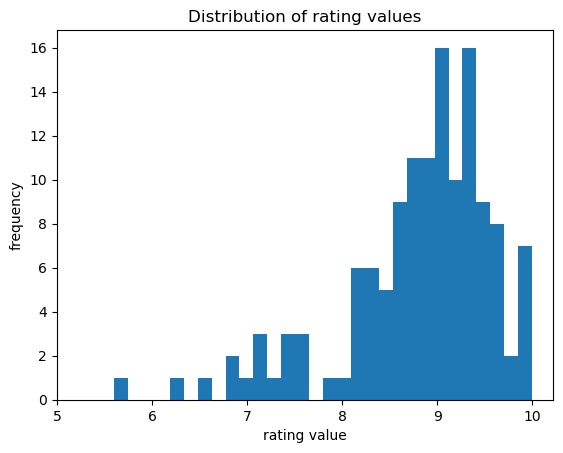

In [667]:
plt.hist(hotels_data.rating, bins = 30)

plt.xticks(range(5, 11))
plt.xlabel("rating value")
plt.ylabel("frequency")
plt.title("Distribution of rating values")

plt.show()

In [739]:
rating_price1_data = hotels_data[['rating', 'price_double_room']].dropna().groupby("rating")["price_double_room"].mean().sort_index(ascending=True)
rating_price2_data = hotels_data[['rating', 'price_big_room']].dropna().groupby("rating")["price_big_room"].mean().sort_index(ascending=True)

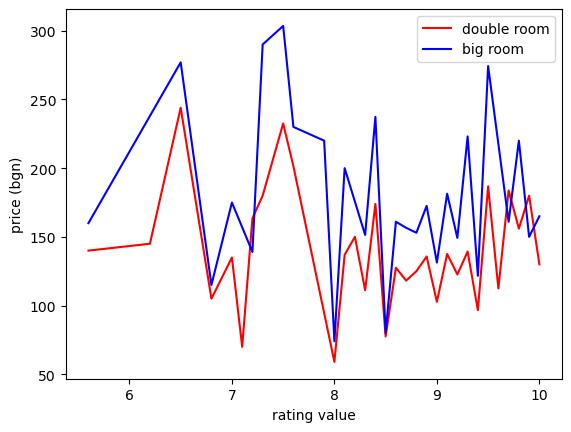

In [740]:
rating_price1_data = hotels_data[['rating', 'price_double_room']].dropna().groupby("rating")["price_double_room"].mean().sort_index(ascending=True)
rating_price2_data = hotels_data[['rating', 'price_big_room']].dropna().groupby("rating")["price_big_room"].mean().sort_index(ascending=True)

plt.plot(rating_price1_data.index, rating_price1_data.values, color="red", label="double room")
plt.plot(rating_price2_data.index, rating_price2_data.values, color="blue", label="big room")

plt.xlabel("rating value")
plt.ylabel("price (bgn)")

plt.legend()
plt.show()

The visualisation shows that hotels with the highest ratings (above 8.5) have an average price range between 100 - 200 lv for double room and 150 - 270 lv for big room.

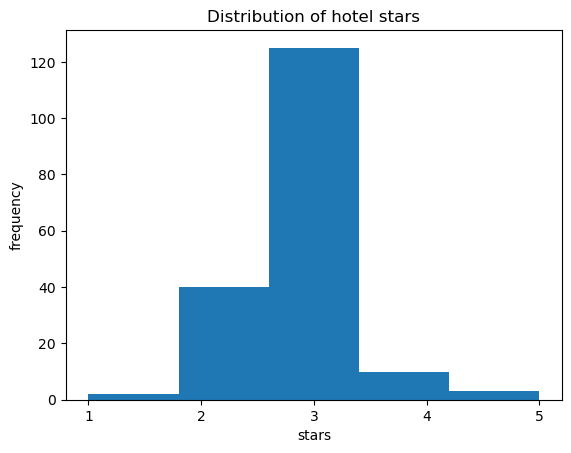

In [578]:
plt.hist(hotels_data.stars, bins = 5)

plt.xticks(range(1, 6, 1))
plt.xlabel("stars")
plt.ylabel("frequency")
plt.title("Distribution of hotel stars")
plt.show()

I remove hotels where all values ​​in columns 'stars', 'price_double_room' and 'price_triple_room' are missing because these records do not provide enough information.

In [700]:
hotels_data = hotels_data.dropna(subset = ['stars', 'price_double_room', 'price_big_room'], how = 'all')
hotels_data.shape

(208, 6)

Lets check amenities column. I clean and tokenize the 'amenities' column. Then i remove stopwords.

In [701]:
hotels_data.amenities[7]

"['паркинг', 'кафене', 'телевизор', 'кухня', 'сателитна тв', 'климатик', 'отопление', 'хладилник', 'интернет', 'баня/тоалетна', 'микровълнова', 'тераса', 'изглед', 'ютия', 'сешоар', 'кухненски бокс', 'плащане с карта', 'кафе машина', 'лятна градина', 'електрическа кана']"

In [702]:
print(isinstance(hotels_data.amenities[7], str))

True


In [741]:
def process_amenities(amenities_str):
    processed_str = amenities_str.replace(
        '[', '').replace(
        ']', '').replace(
        "'", "").replace(
        '/', ' ').replace(
        '-', ' ').replace(
        'отопление', '').replace(
        'бокс', 'кухня').replace(
        'механа', 'ресторант').replace(
        ',', '')
    processed_str = ' '.join(processed_str.split())
    return processed_str

hotels_data['amenities'] = hotels_data['amenities'].apply(process_amenities)

In [742]:
custom_stopwords = ['кухненски', 'кухненска', 'готварска', 'електрическа', 'тв', 'на', 'и', 'в', 'с', 'от', 'за', 'под', 'към', 'по', 'се', 'дом.', 'хим.', 'лятна']

def remove_stop_words(text):
    words = text.split()
    filtered_words = [w for w in words if w not in custom_stopwords] 
    
    return ' '.join(filtered_words)

hotels_data['amenities'] = hotels_data['amenities'].apply(remove_stop_words)

In [743]:
hotels_data['amenities'][7]

'паркинг кафене телевизор кухня сателитна климатик хладилник интернет баня тоалетна микровълнова тераса изглед ютия сешоар кухня плащане карта кафе машина градина кана'

In [744]:
all_words = ' '.join(hotels_data['amenities']).split()
words_frequencies = Counter(all_words)

In [745]:
words_frequencies

Counter({'баня': 220,
         'тоалетна': 212,
         'климатик': 211,
         'телевизор': 207,
         'интернет': 207,
         'тераса': 197,
         'кабелна': 192,
         'хладилник': 186,
         'изглед': 181,
         'басейн': 180,
         'ютия': 179,
         'кухня': 145,
         'бар': 139,
         'сешоар': 124,
         'паркинг': 122,
         'детски': 116,
         'кана': 95,
         'микровълнова': 88,
         'градина': 83,
         'открит': 78,
         'ресторант': 69,
         'сателитна': 69,
         'пране': 69,
         'мини': 66,
         'плащане': 64,
         'карта': 64,
         'кафе': 63,
         'машина': 63,
         'гладене': 62,
         'сейф': 61,
         'кът': 53,
         'пералня': 50,
         'рент': 45,
         'а': 45,
         'кар': 45,
         'кафене': 44,
         'телефон': 43,
         'барбекю': 40,
         'достъп': 35,
         'инвалиди': 35,
         'лоби': 33,
         'охрана': 33,
         'любимци

In [746]:
hotels_data[hotels_data.amenities.str.contains("билярд")]

,name,stars,rating,amenities,price_double_room,price_big_room
17,Ваканционно селище Санта Марина,3.0,8.3,открит басейн паркинг ресторант нощен бар фитн...,NaN,172.0
35,Хотел Лагуна Бийч,4.0,7.5,открит басейн паркинг ресторант фитнес билярд ...,380.0,532.0
53,Апартхотел Мартинез,4.0,8.8,открит басейн паркинг ресторант нощен бар фитн...,172.0,242.0
75,Комплекс Аполония Ризорт,4.0,8.7,открит басейн паркинг ресторант нощен бар фитн...,240.0,290.0
103,Хотел Грийн Лайф Ресорт,4.0,8.4,открит басейн паркинг ресторант фитнес билярд ...,207.0,282.0
141,Хотел Селена,4.0,NaN,открит басейн паркинг ресторант фитнес билярд ...,250.0,288.0


In [752]:
# 'билярд': 6
hotel_stars = hotels_data[hotels_data.amenities.str.contains("билярд")]
round(hotel_stars.stars.mean(), 2)

3.83

In [751]:
# 'ресторант': 69
hotel_stars = hotels_data[hotels_data.amenities.str.contains("ресторант")]
round(hotel_stars.stars.mean(), 2)

3.1

In [753]:
# 'сешоар': 124
hotel_stars = hotels_data[hotels_data.amenities.str.contains("сешоар")]
round(hotel_stars.stars.mean(), 2)

2.99

In [754]:
# 'хладилник': 172
hotel_stars = hotels_data[hotels_data.amenities.str.contains("хладилник")]
round(hotel_stars.stars.mean(), 2)

2.82

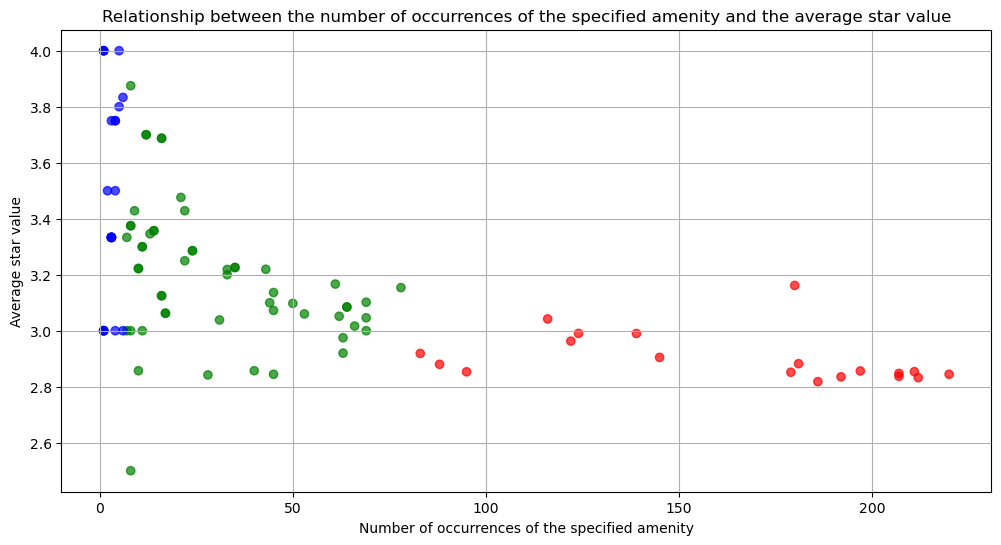

In [755]:
amenities_mean_stars = {}

for amenity in words_frequencies.keys():
    hotels_with_amenity = hotels_data[hotels_data['amenities'].str.contains(amenity)]
    mean_stars = hotels_with_amenity['stars'].mean()
    amenities_mean_stars[amenity] = mean_stars

counts, means, colors = [], [], []

for amenity, count in words_frequencies.items():
    if count > 0: 
        counts.append(count)
        means.append(amenities_mean_stars[amenity])

        if count <= 6:
            colors.append('blue') 
        elif count <= 80:
            colors.append('green')
        else:
            colors.append('red')

plt.figure(figsize = (12, 6))

plt.scatter(counts, means, c=colors, alpha=0.7)
plt.title('Relationship between the number of occurrences of the specified amenity and the average star value')
plt.xlabel('Number of occurrences of the specified amenity')
plt.ylabel('Average star value')
plt.grid(True)
plt.show()

The visualisation shows that the rarer an amenity is, the more luxurious it is in a hotel (hotel with more stars). \
There is a trend that the more frequently an amenity is offered, the lower the average number of stars of the hotels that provide it. Based on this trend, I fill in the missing star values for hotels.

In [756]:
low_frequency_words = {word for word, count in words_frequencies.items() if count <= 6}
medium_frequency_words = {word for word, count in words_frequencies.items() if 7 <= count <= 80}

def fill_stars_based_on_amenities(row):
    if pd.isna(row['stars']):
        words = row['amenities'].split()
        
        # at least 2 of the words has an occurrence count <= 6
        if len([word in low_frequency_words for word in words]) > 3:
            return 4  
        
        # at least 2 of the words has an occurrence count between 7 and 80
        if len([word in medium_frequency_words for word in words]) >= 2:
            return 3  
        
        # fill with a value of 2 stars if there are no words with number of occurrences <= 80
        return 2
    
    return row['stars']

hotels_data['stars'] = hotels_data.apply(fill_stars_based_on_amenities, axis=1)

In [710]:
hotels_data[hotels_data.stars.isna()]

,name,stars,rating,amenities,price_double_room,price_big_room


In [757]:
hotels_data.stars.value_counts()

stars
3.0    125
4.0     43
2.0     40
5.0      3
1.0      2
Name: count, dtype: int64

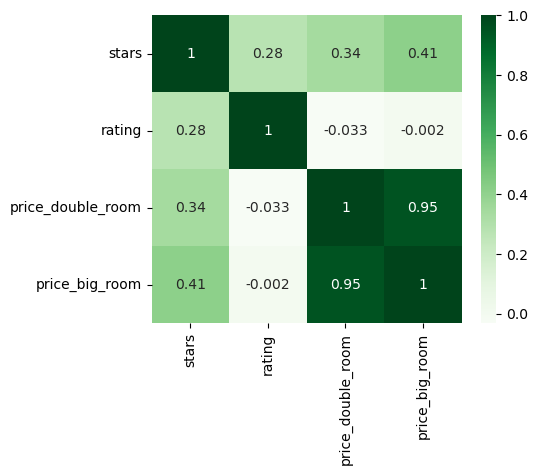

In [758]:
corr_columns = ['stars', 'rating', 'price_double_room', 'price_big_room']

plt.figure(figsize = (5, 4))
corr_matrix = hotels_data[corr_columns].corr()
sns.heatmap(corr_matrix, annot = True, cmap = plt.cm.Greens) 
plt.show()

There is very strong correlation between price_double_room and price_triple_room (0.95) indicating a consistent pricing strategy. There is a moderate positive correlation between the stars of the hotels and the prices for both double and triple rooms. As the stars of a hotel increases, the prices for double and triple rooms also tend to increase.

In [759]:
top_rated_hotels = hotels_data.sort_values('rating', ascending = False).head(20)
top_rated_hotels.stars.value_counts()

stars
4.0    11
3.0     8
5.0     1
Name: count, dtype: int64

In [762]:
hotels_data = hotels_data.dropna(subset = ['price_double_room', 'price_big_room'], how = 'all')
hotels_data.shape

(197, 7)

In [763]:
hotels_data['price_diff'] = hotels_data['price_big_room'] - hotels_data['price_double_room']

mean_difference_by_stars = hotels_data.groupby('stars')['price_diff'].mean().reset_index()

mean_difference_by_stars

,stars,price_diff
0,1.0,25.000000
1,2.0,27.218750
2,3.0,38.554217
3,4.0,53.652174
4,5.0,225.000000


In [764]:
hotels_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 0 to 214
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               197 non-null    object 
 1   stars              197 non-null    float64
 2   rating             124 non-null    float64
 3   amenities          197 non-null    object 
 4   price_double_room  174 non-null    float64
 5   price_big_room     164 non-null    float64
 6   price_diff         141 non-null    float64
dtypes: float64(5), object(2)
memory usage: 12.3+ KB


I remove hotels without rating and check how rating correlates with different amenities:

In [765]:
hotels_data_with_rating = hotels_data.dropna(subset = ['rating'])

In [766]:
count_vectorizer = CountVectorizer(ngram_range = (1, 1), min_df = 1, max_df = 1.0)

count_vectorizer.fit(hotels_data_with_rating.amenities)

vectors = count_vectorizer.transform(hotels_data_with_rating.amenities)

vectors
# count_vectorizer.vocabulary_

features_amenities_df = pd.DataFrame(vectors.toarray(), columns = count_vectorizer.get_feature_names_out())
features_amenities_df['rating'] = hotels_data_with_rating['rating']

In [767]:
vectors

<124x96 sparse matrix of type '<class 'numpy.int64'>'
	with 3048 stored elements in Compressed Sparse Row format>

I calculate the correlation between hotel amenities and their rating and return the top 10 amenities that have the strongest positive correlation with the rating.

In [776]:
corr_matrix = features_amenities_df.corr()
correlation_rating = corr_matrix['rating'].drop('rating')

top_10_amenities = correlation_rating.sort_values(ascending=False).head(15)
top_10_amenities

телевизор       0.313345
кухня           0.295207
печка           0.247523
любимци         0.195408
пералня         0.179199
интернет        0.171895
кана            0.169407
камина          0.160938
радио           0.160206
микровълнова    0.153530
кафе            0.140189
машина          0.140189
сателитна       0.136327
съдомиялна      0.131836
сушилня         0.126812
Name: rating, dtype: float64

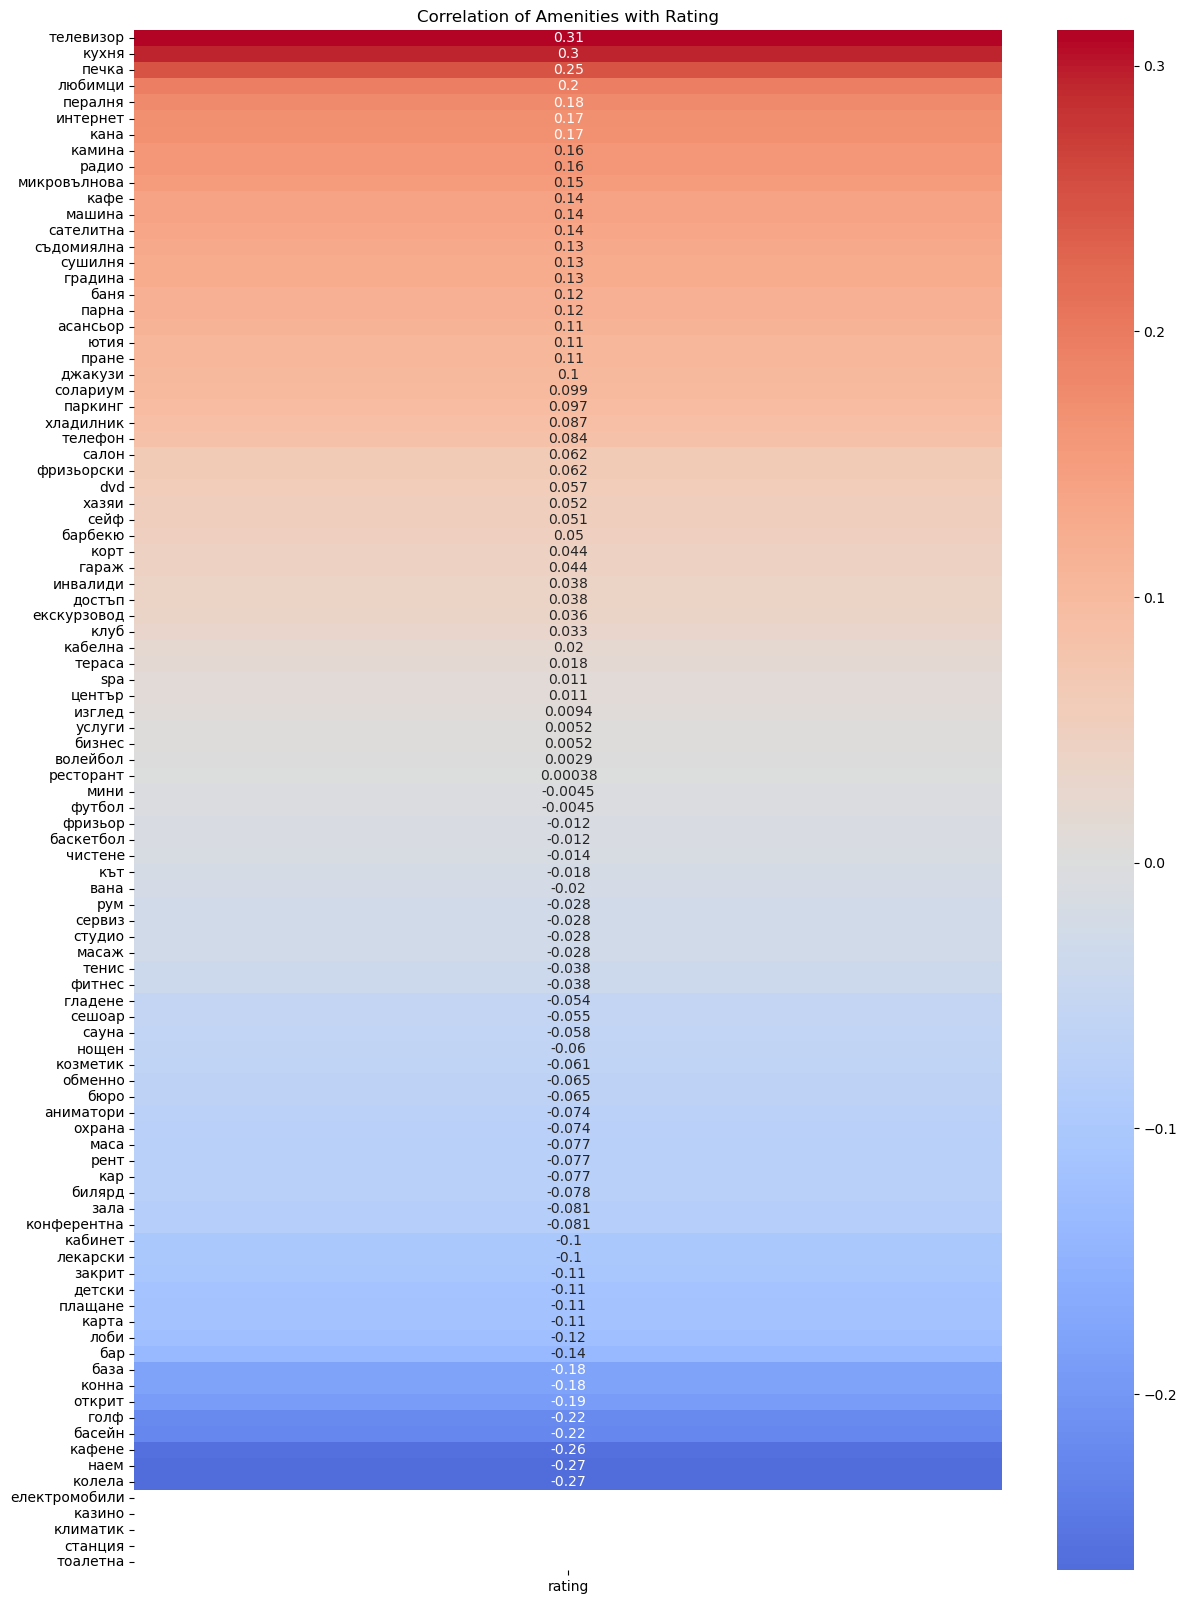

In [777]:
fig, ax = plt.subplots(figsize = (14, 20))
sns.heatmap(correlation_rating.to_frame().sort_values(by='rating', ascending=False), 
            annot=True, cmap='coolwarm', center=0, ax=ax)

ax.set_title('Correlation of Amenities with Rating')
plt.show()

I find the top 10 cheapest hotels that contain all these 3 amenities:

In [782]:
top_3_amenities = ['телевизор', 'кухня', 'печка']

def get_hotels_with_top_amenities(hotels_data, top_3_amenities):
    filtered_hotels = []
    
    for index, row in hotels_data.iterrows():
        set_amenities = set(row['amenities'].split())
         # цheck if all top_3_amenities are in set_amenities:
        if all(amenity in set_amenities for amenity in top_3_amenities):
            filtered_hotels.append(row)
    
    filtered_hotels_df = pd.DataFrame(filtered_hotels)
    sorted_hotels = filtered_hotels_df.sort_values(by='price_double_room')
    best_hotels = sorted_hotels[sorted_hotels['rating'] > 9]
        
    return best_hotels

best_hotels_by_amenitites_rating = get_hotels_with_top_amenities(hotels_data, top_3_amenities)

In [1014]:
best_hotels_by_amenitites_rating

,name,stars,rating,amenities,price_double_room,price_big_room,price_diff
61,Дом Апостолови,4.0,9.7,телевизор кухня кабелна климатик хладилник мин...,90.0,110.0,20.0
156,Чери Вила,3.0,9.3,паркинг рент а кар охрана детски кът барбекю к...,90.0,125.0,35.0
67,Къща Kатерков,2.0,9.1,телевизор кухня кабелна климатик хладилник инт...,120.0,155.0,35.0
27,Хотел Долфин Бей Созопол,4.0,9.7,открит басейн паркинг рум сервиз детски басейн...,290.0,380.0,90.0
26,Апартамент А19 в Созополи хилс,3.0,9.9,открит басейн паркинг фитнес детски кът детски...,NaN,150.0,NaN
39,Къща за гости Феникс,4.0,10.0,барбекю камина телевизор кухня кабелна сателит...,NaN,165.0,NaN
120,Хотел Созополис Холидей Вилидж,4.0,9.3,открит басейн паркинг ресторант фитнес рент а ...,NaN,370.0,NaN
144,Къща Желеви,3.0,9.1,телевизор кухня кабелна климатик хладилник инт...,NaN,100.0,NaN
170,Апарт комплекс Елинор Буджака,4.0,9.5,открит басейн паркинг телевизор кухня кабелна ...,NaN,150.0,NaN
191,Апартамент в Грийн Лайф морска гледка,5.0,9.8,открит басейн паркинг ресторант охрана детски ...,NaN,220.0,NaN


In [786]:
best_hotels_by_amenitites_rating.describe().T

,count,mean,std,min,25%,50%,75%,max
stars,10.0,3.60,0.843274,2.0,3.00,4.0,4.000,5.0
rating,10.0,9.54,0.327278,9.1,9.30,9.6,9.775,10.0
price_double_room,4.0,147.50,96.046864,90.0,90.00,105.0,162.500,290.0
price_big_room,10.0,192.50,101.714470,100.0,131.25,152.5,206.250,380.0
price_diff,4.0,45.00,30.822070,20.0,31.25,35.0,48.750,90.0


### Hotel reviews dataset:

In [901]:
reviews_data = pd.read_csv("data/reviews_hotels_data.csv")

In [902]:
reviews_data.head(3)

,Unnamed: 0,hotel_name,review_rating_score,pos_review_content,neg_review_content
0,0,Комплекс Вили над залива,10,"Супер локация, много е удобна ако искате да по...","Широко и удобно, има паркомясто и удобна локац..."
1,1,Комплекс Вили над залива,10,Уникално и любезно отношение от собствениците....,Всичко беше супер. Нямам лош коментар!!!
2,2,Семеен хотел Елена,9,Стаята на живо е по-хубава от на снимките голя...,NaN


In [903]:
reviews_data = reviews_data.drop(columns = {"Unnamed: 0", "review_rating_score"})

In [904]:
reviews_data.rename(columns={'hotel_name': 'name'}, inplace=True)

In [905]:
reviews_data = reviews_data[reviews_data['name'].isin(hotels_data_with_rating['name'])]

In [906]:
reviews_data = reviews_data.reset_index(drop=True)

In [907]:
reviews_data = pd.merge(reviews_data, hotels_data_with_rating[['name', 'rating']], on='name', how='left')

In [908]:
reviews_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2012 entries, 0 to 2011
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                2012 non-null   object 
 1   pos_review_content  1908 non-null   object 
 2   neg_review_content  1206 non-null   object 
 3   rating              2012 non-null   float64
dtypes: float64(1), object(3)
memory usage: 63.0+ KB


In [909]:
reviews_data[(reviews_data.pos_review_content.isna()) & (reviews_data.neg_review_content.isna())]

,name,pos_review_content,neg_review_content,rating
1623,Къща Ани,NaN,NaN,9.1


In [910]:
reviews_data = reviews_data.drop(index = 1623)

In [911]:
# I use the Bulgarian model 'bg_news_lg' from spacy

nlp = spacy.load('bg_news_lg')

def process_reviews(reviews):
    if pd.isna(reviews):
        return ''
        
    reviews = reviews.lower()
    text = nlp(reviews)
    processed_tokens = [token.lemma_ for token in text if not token.is_stop and not token.is_punct]
    processed_reviews = ' '.join(processed_tokens)
    
    return processed_reviews


reviews_data['processed_pos_review'] = reviews_data['pos_review_content'].apply(process_reviews)
reviews_data['processed_neg_review'] = reviews_data['neg_review_content'].apply(process_reviews)

In [912]:
reviews_data.sample(5)

,name,pos_review_content,neg_review_content,rating,processed_pos_review,processed_neg_review
1803,Семеен хотел Радиана,Това е един от най-хубавите хотели по нашето Ч...,NaN,9.9,хубав хотел наш черноморие стаите приятно обза...,
1491,"Арт Комплекс Анел, Буджака","парко мястото до къщичката, размера на стаята ...",може би закуската би било по-добре да е блок маса,9.3,парко място къщичка размер стая тераса възможн...,закуска блок маса
1823,Хотел Серена Резиденс,Почти всичко!,"Един недостатък, сервитьорите бързаха да вдигн...",7.2,,недостатък сервитьор бързам вдигна-(се) маса
158,Хотел Сиена Хаус,Всичко много ни хареса. Близо до центъра и пла...,Няма опция за хранене,8.7,харесам-(се) център плаж паркинг,опция хранене
916,Семеен хотел Чучулев,Разположението е страхотно - хотелът е точно м...,Може би нещо съвсем мъничко - леглото в двойна...,8.9,разположение страхотно хотел два централен пла...,мъничко легло двойен стая единичен събера-(се)...


In [913]:
def process_neg_reviews(reviews):
    processed_str = reviews.replace('не харесам-(се)', '').replace('харесам-(се)', '').replace('такъв', '').replace('стаа', '')
    processed_str = ' '.join(processed_str.split())
    return processed_str

reviews_data['processed_neg_review'] = reviews_data['processed_neg_review'].apply(process_neg_reviews)

In [914]:
all_pos_review_words = ' '.join(reviews_data['processed_pos_review']).split()
pos_review_words_frequencies = Counter(all_pos_review_words)

all_neg_review_words = ' '.join(reviews_data['processed_neg_review']).split()
neg_review_words_frequencies = Counter(all_neg_review_words)

In [915]:
pos_review_words_frequencies.most_common(20)

[('хотел', 591),
 ('персонал', 528),
 ('стая', 435),
 ('място', 434),
 ('плаж', 429),
 ('любезен', 371),
 ('чист', 365),
 ('гледка', 356),
 ('локация', 346),
 ('чисто', 263),
 ('местоположение', 248),
 ('закуска', 237),
 ('прекрасен', 230),
 ('голям', 222),
 ('страхотен', 221),
 ('изключително', 221),
 ('басейн', 213),
 ('отзивчив', 210),
 ('домакин', 206),
 ('море', 194)]

In [916]:
neg_review_words_frequencies.most_common(20)

[('не', 666),
 ('стая', 268),
 ('хотел', 179),
 ('баня', 175),
 ('нямам', 166),
 ('имам', 142),
 ('място', 117),
 ('закуска', 110),
 ('паркинг', 108),
 ('ресторант', 83),
 ('вода', 79),
 ('малък', 79),
 ('работя', 70),
 ('храна', 69),
 ('цена', 66),
 ('плаж', 59),
 ('персонал', 58),
 ('тераса', 57),
 ('басейн', 56),
 ('проблем', 55)]

In [917]:
reviews_data['length_pos_review'] = reviews_data['pos_review_content'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
reviews_data['length_neg_review'] = reviews_data['neg_review_content'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

mean_length_pos_reviews = reviews_data['length_pos_review'].mean()
mean_length_neg_reviews = reviews_data['length_neg_review'].mean()

print(f"Mean length of positive reviews: {round(mean_length_pos_reviews)}.")
print(f"Mean length of negative reviews: {round(mean_length_neg_reviews)}.")

Mean length of positive reviews: 130.
Mean length of negative reviews: 78.


In [918]:
hotels_with_pos_review_only = reviews_data[reviews_data.neg_review_content.isna()]['rating']
hotels_with_neg_review_only = reviews_data[reviews_data.pos_review_content.isna()]['rating']

print(f"Mean rating of hotels with negative reviews only is {hotels_with_neg_review_only.mean():.2f}")
print(f"Mean rating of hotels with positive reviews only is {hotels_with_pos_review_only.mean():.2f}")

Mean rating of hotels with negative reviews only is 8.18
Mean rating of hotels with positive reviews only is 9.00


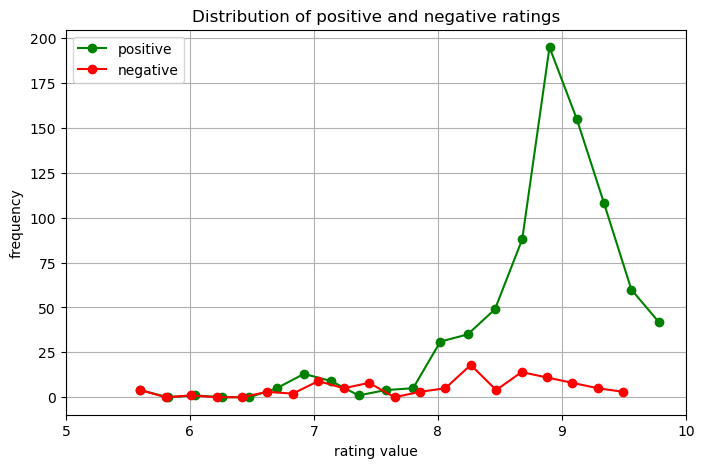

In [919]:
counts1, bin_edges1 = np.histogram(hotels_with_pos_review_only, bins = 20)  
counts2, bin_edges2 = np.histogram(hotels_with_neg_review_only, bins = 20)  

plt.figure(figsize=(8, 5))
plt.plot(bin_edges1[:-1], counts1, linestyle='-', marker='o', color = "green", label = "positive") 
plt.plot(bin_edges2[:-1], counts2, linestyle='-', marker='o', color = "red", label = "negative") 

plt.xlabel('rating value')
plt.ylabel('frequency')
plt.xticks(range(5, 11))
plt.title('Distribution of positive and negative ratings')
plt.legend(loc = 'upper left')

plt.grid(True)
plt.show()

The histogram shows how frequently different rating values occur in only positive reviews and only negative reviews, which helps to visualize and compare the distribution of ratings between hotels with positive and negative reviews.

In [930]:
stop_words = ['и', 'или', 'в', 'на', 'с', 'за', 'се', 'от', 'по', 'не', 'така', 'които', 'има', 'имам', 'да', 'е', 'са']

count_vectorizer_pos = CountVectorizer(stop_words=stop_words, ngram_range = (1, 2), min_df = 3, max_df = 0.95)

count_vectorizer_pos.fit(reviews_data.processed_pos_review)

vectors_pos = count_vectorizer_pos.transform(reviews_data.processed_pos_review)

features_pos_review = pd.DataFrame(vectors_pos.toarray(), columns = count_vectorizer_pos.get_feature_names_out())

features_pos_review['rating'] = reviews_data['rating']

In [1030]:
correlation_matrix_pos = features_pos_review.corr()
rating_correlation_pos = correlation_matrix_pos['rating'].drop('rating')
top_10_words = rating_correlation_pos.sort_values(ascending=False).head(10)

In [1031]:
top_10_words

домакин         0.179239
изключително    0.172370
любезен         0.149419
препоръчвам     0.138872
собственик      0.135856
място           0.130084
прекрасен       0.128260
мил             0.120150
страхотен       0.114514
чисто           0.112139
Name: rating, dtype: float64

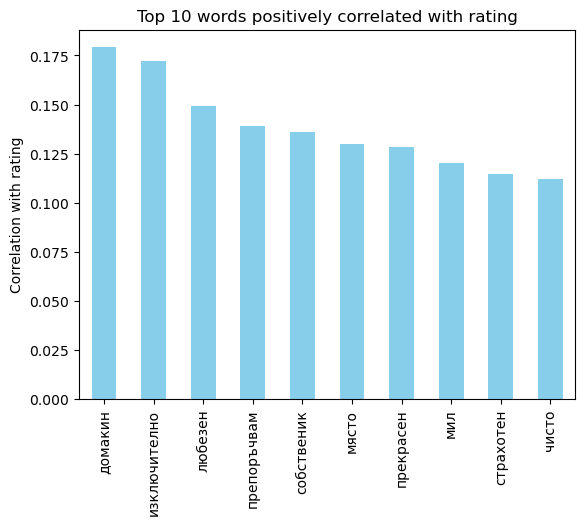

In [1032]:
top_10_words.plot(kind='bar', color='skyblue')

plt.ylabel('Correlation with rating')
plt.title('Top 10 words positively correlated with rating')

plt.show()

The visualisation shows the 10 words that are associated with the highest ratings in the context of positive reviews.

In [931]:
count_vectorizer_neg = CountVectorizer(stop_words=stop_words, ngram_range = (1, 2), min_df = 3, max_df = 0.95)

count_vectorizer_neg.fit(reviews_data.processed_neg_review)

vectors_neg = count_vectorizer_neg.transform(reviews_data.processed_neg_review)

features_neg_review = pd.DataFrame(vectors_neg.toarray(), columns = count_vectorizer_neg.get_feature_names_out())

features_neg_review['rating'] = reviews_data['rating']

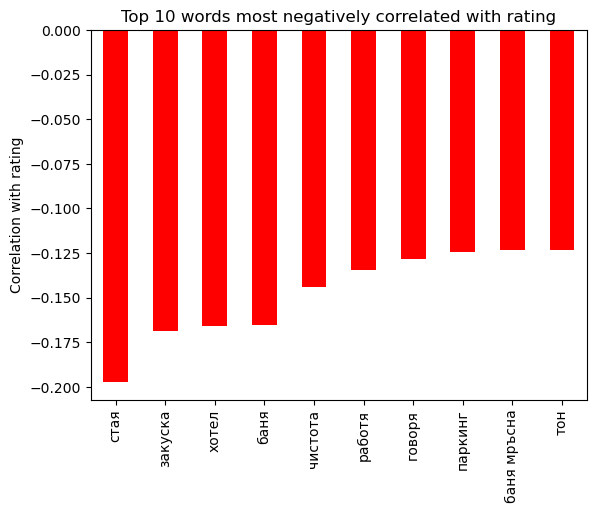

In [932]:
correlation_matrix_neg = features_neg_review.corr()
rating_correlation_neg = correlation_matrix_neg['rating'].drop('rating')
# the 10 words with the lowest correlation:
top_10_words_neg = rating_correlation_neg.sort_values(ascending=True).head(10)

top_10_words_neg.plot(kind='bar', color='red')

plt.title('Top 10 words most negatively correlated with rating')
plt.ylabel('Correlation with rating')

plt.show()

The visualisation shows the 10 words that are associated with the lowest ratings in the context of negative reviews.

Lets check words from positive and negative reviews overall by TF-IDF:

In [989]:
positive_reviews = reviews_data[reviews_data['processed_pos_review'].notna()]['processed_pos_review']
negative_reviews = reviews_data[reviews_data['processed_neg_review'].notna()]['processed_neg_review']

In [1005]:
bulgarian_stopwords = [
    'и', 'в', 'на', 'с', 'за', 'от', 'до', 'че', 'както', 'бъде', 'се', 'е', 'са', 'към',
    'този', 'тези', 'всеки', 'кога', 'някой', 'ако', 'не', 'или', 'по', 'от', 'също', 'имам']

tfidf_vectorizer = TfidfVectorizer(stop_words=bulgarian_stopwords, ngram_range=(1, 2))

tfidf_pos = tfidf_vectorizer.fit_transform(positive_reviews)
features_pos = tfidf_vectorizer.get_feature_names_out()

tfidf_neg = tfidf_vectorizer.transform(negative_reviews)
features_neg = tfidf_vectorizer.get_feature_names_out()

df_pos = pd.DataFrame(tfidf_pos.toarray(), columns=features_pos)
df_neg = pd.DataFrame(tfidf_neg.toarray(), columns=features_neg)

mean_tfidf_pos = df_pos.mean().sort_values(ascending=False)
mean_tfidf_neg = df_neg.mean().sort_values(ascending=False)

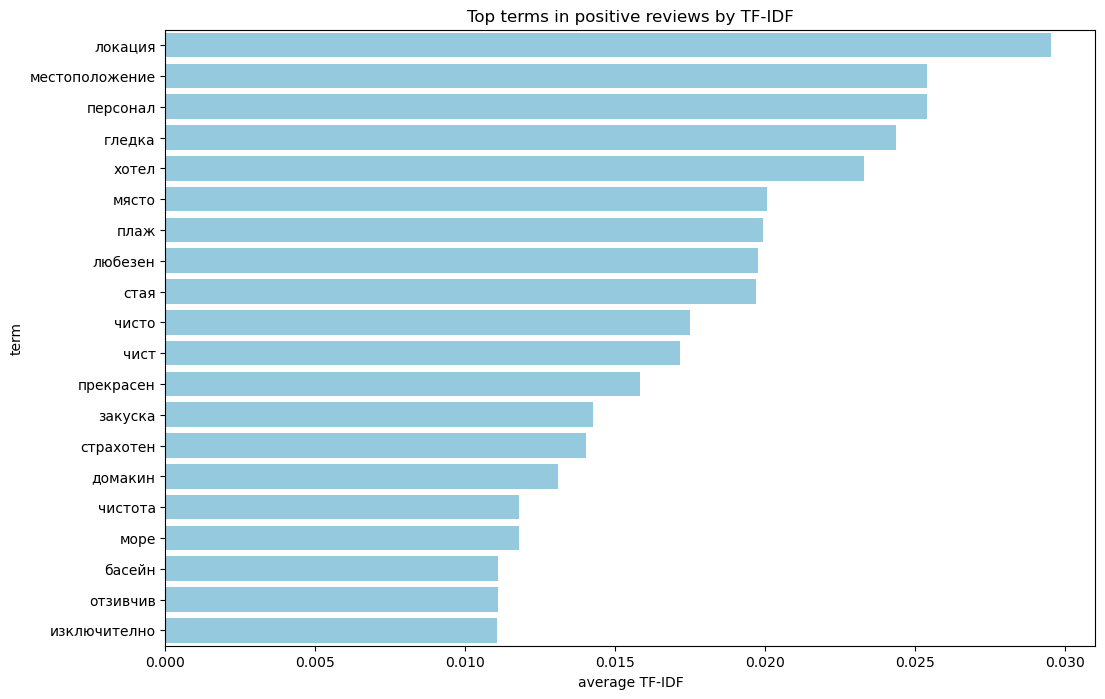

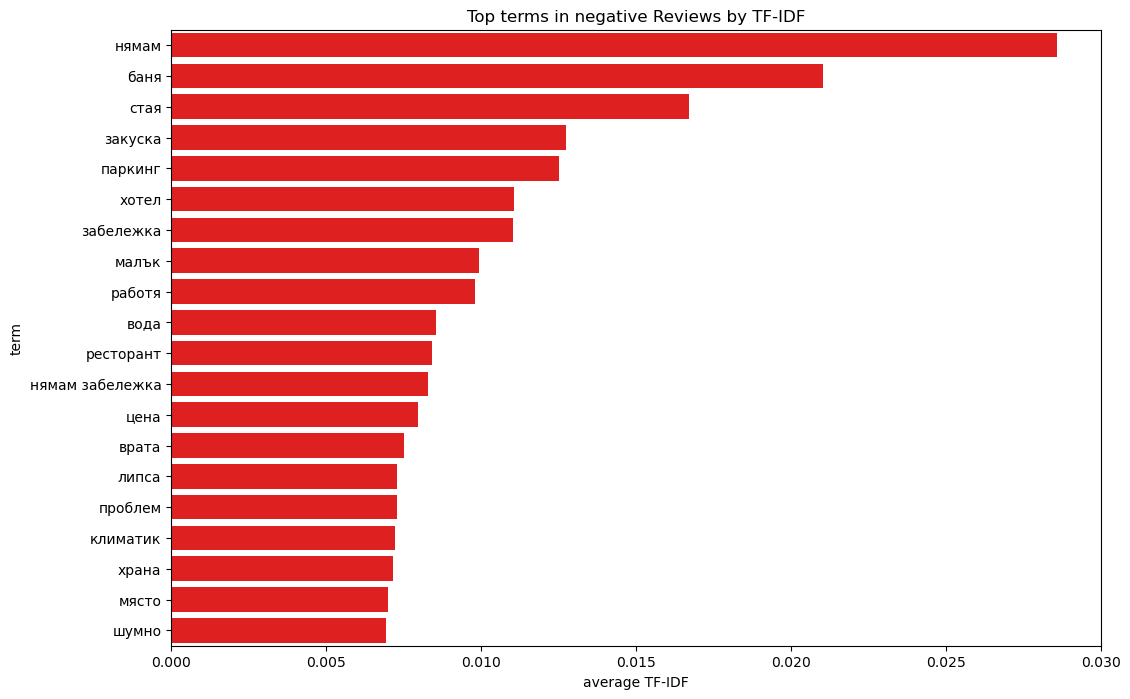

In [1006]:
def plot_top_terms(mean_tfidf, title, color):
    top_terms = mean_tfidf.head(20)
    plt.figure(figsize = (12, 8))
    sns.barplot(x=top_terms.values, y=top_terms.index, color=color)
    plt.title(title)
    plt.ylabel('term')
    plt.xlabel('average TF-IDF')
    plt.show()

plot_top_terms(mean_tfidf_pos, 'Top terms in positive reviews by TF-IDF', color = "skyblue")
plot_top_terms(mean_tfidf_neg, 'Top terms in negative Reviews by TF-IDF', color = "red")

In [1046]:
merged_data = pd.merge(hotels_data, reviews_data, on=['name', 'rating'])

merged_data['processed_neg_review'] = merged_data['processed_neg_review'].replace('', np.nan)

hotels_with_only_positive_reviews = merged_data[merged_data['processed_neg_review'].isna()]

hotels_grouped = hotels_with_only_positive_reviews.groupby('name').agg({
    'rating': 'mean',
}).reset_index()

top_rated_hotels = hotels_grouped.sort_values(by='rating', ascending=False)
top_rated_10_hotels = top_rated_hotels.head(10)
top_rated_10_hotels

,name,rating
10,Вила Диди,10.0
26,Къща за гости Феникс,10.0
38,Семеен хотел Гая,9.9
2,Апартамент А19 в Созополи хилс,9.9
56,Семеен хотел Радиана,9.9
65,Фиорд B&B,9.8
16,Дом Апостолови,9.7
78,Хотел Долфин Бей Созопол,9.7
41,Семеен хотел Екзотик,9.7
43,Семеен хотел Емилия,9.7


In [1048]:
hotels_data[hotels_data['name'].isin(top_rated_10_hotels.name)]

,name,stars,rating,amenities,price_double_room,price_big_room,price_diff
9,Семеен хотел Емилия,3.0,9.7,паркинг телевизор кабелна климатик хладилник м...,NaN,95.0,NaN
26,Апартамент А19 в Созополи хилс,3.0,9.9,открит басейн паркинг фитнес детски кът детски...,NaN,150.0,NaN
27,Хотел Долфин Бей Созопол,4.0,9.7,открит басейн паркинг рум сервиз детски басейн...,290.0,380.0,90.0
39,Къща за гости Феникс,4.0,10.0,барбекю камина телевизор кухня кабелна сателит...,NaN,165.0,NaN
60,Семеен хотел Екзотик,3.0,9.7,телевизор кабелна климатик хладилник интернет ...,60.0,80.0,20.0
61,Дом Апостолови,4.0,9.7,телевизор кухня кабелна климатик хладилник мин...,90.0,110.0,20.0
66,Семеен хотел Радиана,3.0,9.9,паркинг рент а кар джакузи колела наем телевиз...,150.0,NaN,NaN
164,Семеен хотел Гая,4.0,9.9,телевизор кабелна климатик хладилник интернет ...,210.0,NaN,NaN
182,Вила Диди,4.0,10.0,паркинг телевизор кабелна климатик хладилник и...,130.0,NaN,NaN
206,Фиорд B&B,3.0,9.8,паркинг сейф лоби бар телевизор кабелна климат...,156.0,NaN,NaN


These hotels have exceptionally high ratings (9.9 or 10.0) and do not have any negative reviews, making them stand out in the dataset. The absence of negative reviews suggests either outstanding service or a highly satisfied customer base.

## 5. Results and conclusion

**Statistics оverview**:

* 75% of hotels have 3 stars or less.
* The average rating of hotels is high, with a mean of 8.80. The highest rating is 10, suggesting that some hotels are highly rated - 'Вила Диди' and 'Къща за гости Феникс'. The have 4 stars. While the minimum rating of 5.6 is for 'Хотел Созопол', which have 1 star and relatively high price (140lv for double room and 160 lv for big room). 
* The hotels with the highest ratings (above 8.5) have an average price range between 100 - 200 lv for double room and 150 - 270 lv for big room.
* Prices for double rooms vary significantly, with a mean price of 118.48 and a high standard deviation of 63.52, indicating considerable variability. The range of prices is from 30 to 380, showing a wide disparity in pricing.
* Prices for big rooms have an even wider range than for double rooms, with a mean of 156.81 and a maximum price of 548. The variability is also high.
* The hotels with the highest ratings (above 8.5) have an average price range between 100 - 200 lv for double room and 150 - 270 lv for big room.
* Top rated hotels have 4 stars (11 hotels), 3 stars (8 hotels) and 5 stars (one hotel).

I looked at how hotel amenities relate to their ratings and found the top 3 amenities ('телевизор', 'кухня', 'печка') that have the strongest positive impact on ratings. Then I identified the top 10 cheapest hotels that have all three of these highly-rated amenities. 

  -	Дом Апостолови
  - Чери Вила
  - Къща Kатерков
  - Хотел Долфин Бей Созопол
  - Апартамент А19 в Созополи хилс
  - Къща за гости Феникс
  - Хотел Созополис Холидей Вилидж
  - Къща Желеви
  - Апарт комплекс Елинор Буджака
  - Апартамент в Грийн Лайф


    
**Reviews analysis:**

Positive reviews are longer (130 characters on average) perhaps satisfied users are more motivated to write longer reviews, detailing what they liked - amenities, service, atmosphere etc.
 On the other hand, negative reviews may be shorter (78 characters on average) if users feel less committed to describing the negative aspects or if they are more specific and concise in their criticisms.

Hoteliers should emphasize and improve the cleanliness of the bathroom and room, availability of parking, availability of breakfast, availability of air conditioning.

For customers, the presence of a TV, kitchen, cleanliness is essential. The location of the hotel, the good attitude of the hoteliers and staff, presence of a nice view, pool are important.